[0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0]
####
0
1


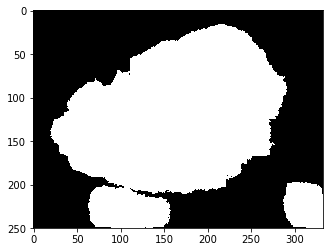

In [93]:
from skimage.transform import rescale
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

%matplotlib inline

cluster_im = Image.open('../../cmean_out/ISIC_0000000_visual.png')
original_im = Image.open('../../ISIC-2017_Training_Data/ISIC_0000000.jpg')
rgb_cluster_im = cluster_im.convert('RGB')
rgb_original_im = original_im.convert('RGB')

scale_factor = float(cluster_im.size[0]) / float(original_im.size[0])

clusters = {}

#collect pixel values for each cluster
width, height = cluster_im.size
for y in range(height):
    for x in range(width):
        r, g, b = rgb_cluster_im.getpixel((x, y))
        cluster_id = str(r) + '-' + str(g) + '-' + str(b)
        
        original_rgb = rgb_original_im.getpixel((x/scale_factor, y/scale_factor)) #.3258 to deal with scale difference
        
        if cluster_id in clusters:
            clusters[cluster_id].append(original_rgb)
        else:
            clusters[cluster_id] = [original_rgb]
            
cluster_averages = {}
            
#get average colour of clusters
for cluster_id in clusters:
    r, g, b = 0, 0, 0
    count = 0
    for pixel in clusters[cluster_id]:
        r += pixel[0]
        g += pixel[1]
        b += pixel[2]
        count += 1
    cluster_averages[cluster_id] = ((r/count), (g/count), (b/count))

#Create Data for clustering
list_of_pixels = []
list_of_ids = {}
counter = 0
for cluster_id in cluster_averages:
    list_of_ids[cluster_id] = counter
    counter += 1
    list_of_pixels.append(list(cluster_averages[cluster_id]))

cvecs = np.array(list_of_pixels)

#Cluster using k-means
kmns = KMeans(n_clusters=2, random_state=1729)
kmns.fit(cvecs)

# print list_of_ids

#Generate output using clustered labels
# for label in kmns.labels_:
#     print label
print  kmns.labels_
print '####'
print kmns.labels_[0]
print kmns.labels_[1]
    
output = Image.new( 'RGB', (width,height), "black") # create a new black image
output_pixels = output.load() # create the pixel map

width, height = cluster_im.size
for y in range(height):
    for x in range(width):
        r, g, b = rgb_cluster_im.getpixel((x, y))
        cluster_id = str(r) + '-' + str(g) + '-' + str(b)
        index = list_of_ids[cluster_id]
        if kmns.labels_[index]:
            output_pixels[x,y] = (255, 255, 255) # set the colour accordingly

plt.imshow(output)